## Genome-scan p-values by super population

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')

from segmenter import segment_to_p, segment_to_Z
from browser import SPops, Pops

locvars = ['Chromosome', 'start', 'end']

In [2]:
# Read gene information
ann = pd.read_csv('gene_result.txt', sep="\t")
ann = ann.rename(columns = {'start_position_on_the_genomic_accession': 'start',
                            'end_position_on_the_genomic_accession': 'end',
                            'chromosome': 'Chromosome'})[['Chromosome', 'start', 'end', 'Symbol']]
ann = ann[~((ann['Chromosome'] == 'X') | ((ann['Chromosome'] == 'Y')))]

ann['Chromosome'] = ann['Chromosome'].astype('int')
ann = ann.sort_values(['Chromosome', 'start', 'end']).reset_index(drop = True)
ann = ann.set_index('Symbol')

In [3]:
def pscan_by_spop(key, spop, chrno = None, start = 0, end = np.inf, gene = None, around = None, weights = 'gaussian',
                 selection='directional', ax = plt):
    ret = {}
    if ((gene is not None) & (around is not None)):
        x = ann.loc[gene]
        
        chrno = x['Chromosome']
        start = x['start']-around
        end = x['end']+around     
        
        ret['gp'] = (start+end)/2        
        
        
    pops = [i for i in range(26) if SPops[i]==spop]
    for pop in pops:
        if key[-5:] == 'Cmedi':
            df = pd.read_csv('merged/s'+str(pop)+'Cmedi.csv')
        else:
            df = pd.read_csv('merged/s'+str(pop)+'.csv')
            
        mu_g = df[key].mean()
        df = df[df['Chromosome'] == chrno].copy()        
        
        df = df[(df['start']>start)&(df['end']<end)]
        cov = pd.read_csv('lags/'+key+'.csv').loc[:,str(pop)].to_numpy()
        cps, pvals = segment_to_p(df, key, mu_g, cov, weights = weights)
        if selection == 'balancing':
            ax.plot(cps, 1-pvals, label = Pops[pop][:3])
        else:
            ax.plot(cps, pvals, label = Pops[pop][:3])
        
        try:
            ax.yscale('log')
        except:
            ax.set_yscale('log')
    
    ret['df'] = df
    ret['chrno'] = chrno
    return ret

In [4]:
def Zscan_by_spop(key, spop, chrno = None, start = 0, end = np.inf, gene = None, around = None, weights = 'gaussian', 
                  ax = plt):
    ret = {}
    if ((gene is not None) & (around is not None)):
        x = ann.loc[gene]
        
        chrno = x['Chromosome']
        start = x['start']-around
        end = x['end']+around     
        
        ret['gp'] = (start+end)/2        
        
        
    pops = [i for i in range(26) if SPops[i]==spop]
    for pop in pops:
        if key[-5:] == 'Cmedi':
            df = pd.read_csv('merged/s'+str(pop)+'Cmedi.csv')
        else:
            df = pd.read_csv('merged/s'+str(pop)+'.csv')
            
        mu_g = df[key].mean()
        df = df[df['Chromosome'] == chrno].copy()        
        
        df = df[(df['start']>start)&(df['end']<end)]
        cov = pd.read_csv('lags/'+key+'.csv').loc[:,str(pop)].to_numpy()
        cps, zvals = segment_to_Z(df, key, mu_g, cov, weights = weights)
        ax.plot(cps, zvals, label = Pops[pop][:3])
    
    ret['df'] = df
    ret['chrno'] = chrno
    return ret

In [5]:
def sscan_by_pop(key, pop, chrno = None, start = 0, end = np.inf, gene = None, around = None, hi = None, ax = plt):
    if ((gene is not None) & (around is not None)):
        x = ann.loc[gene]
        
        chrno = x['Chromosome']
        start = x['start']-around
        end = x['end']+around   
    
    pop = [i for i in range(26) if Pops[i][:3]==pop][0]
    
    segment = 's'+key
    df = pd.read_csv('raw/s'+str(pop)+'_'+str(chrno)+'.csv')
    df = df[locvars+[key, segment]].copy()
    df = df[(df['start']>start)&(df['end']<end)]
    
    from itertools import cycle
    colors = cycle(['gray', 'darkgrey'])
    from scipy.ndimage import gaussian_filter1d
    for i in df[segment].unique():    
        tmp = df[df[segment] == i].copy()
        x = tmp['start'].to_numpy()
        
        if hi is not None:
            if (x[0]<loc) & (x[-1]>loc):
                color = 'red'
            else:
                color = next(colors)
        else:
            color = next(colors)

        y = tmp[key].to_numpy()   
        ax.plot(x, y, c = color, linewidth = 0.5)

# P values of the segments

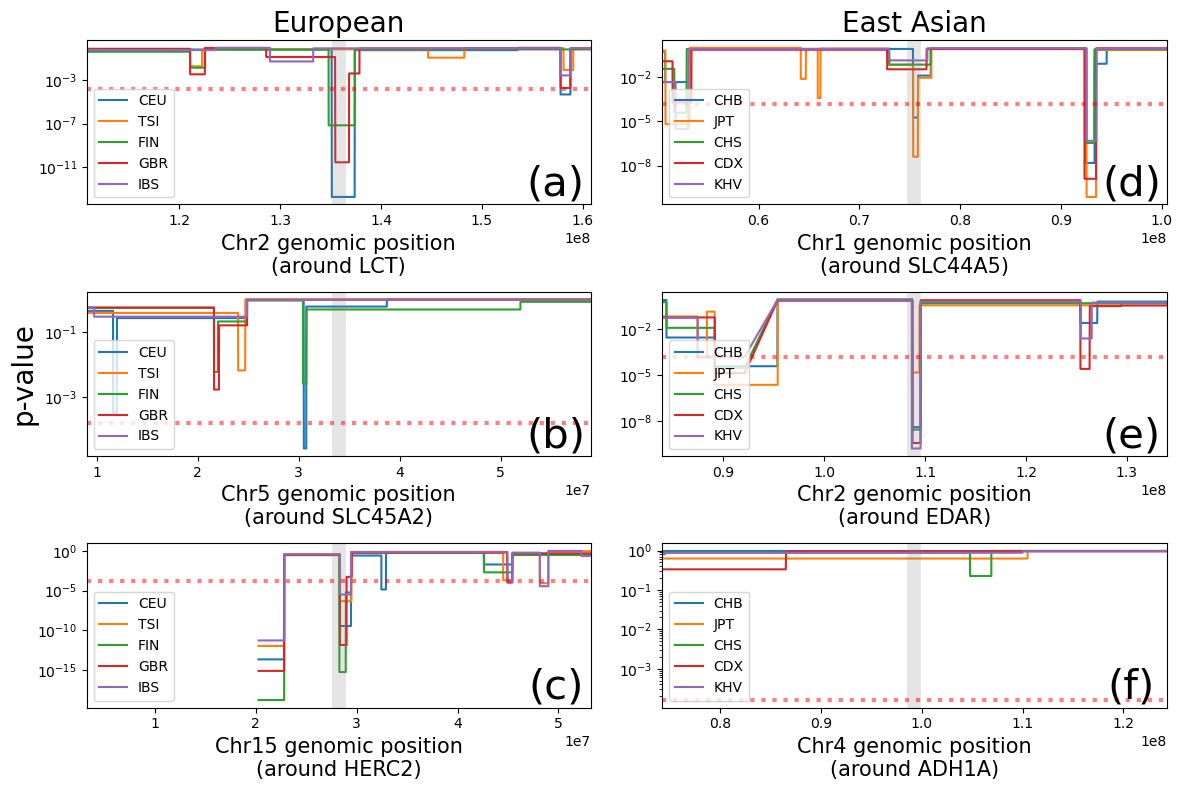

In [26]:
key = 'btree'

genes = iter(["LCT", "SLC44A5", "SLC45A2", "EDAR", "HERC2", "ADH1A"])
spops = iter(["EUR", "EAS", "EUR", "EAS", "EUR", "EAS"])

letters = iter(['a', 'd', 'b', 'e', 'c', 'f'])

nrows = 3
ncols = 2
around = 2.5e7

fig, ax = plt.subplots(nrows,ncols,figsize = (12,8))

for i in range(nrows):
    for j in range(ncols):
        gene = next(genes)
        spop = next(spops)
        ret = pscan_by_spop(key, spop, gene = gene, around = around, weights='gaussian', ax = ax[i, j])
        ax[i, j].legend(loc = "lower left")
        ax[i, j].set_xlabel('Chr'+str(ret['chrno'])+' genomic position\n(around '+gene+')', size = 15)
        #ax[i, j].set_ylabel('p-value')
        ax[i, j].axvline(ret['gp'], linewidth = 10, color = 'Gray', alpha = 0.2)
        ax[i, j].set_xlim(ret['gp']-around, ret['gp']+around)
        ax[i, j].axhline(1.6e-4, color = 'red', linestyle = 'dotted', alpha = 0.5, linewidth = 3)
        ax[i, j].text(1-0.07, 0.12, '('+next(letters)+')', fontsize=30,
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax[i, j].transAxes)
        
ax[1, 0].set_ylabel('p-value', fontsize = 20)
#ax[1, 1].set_ylabel('p-value', fontsize = 30)

plt.subplots_adjust(wspace=2)
ax[0, 0].set_title('European', size = 20)
ax[0, 1].set_title('East Asian', size = 20)
fig.tight_layout()
plt.savefig('genome_scan_plots/multiple_genes_'+key+'.jpg', dpi = 300)

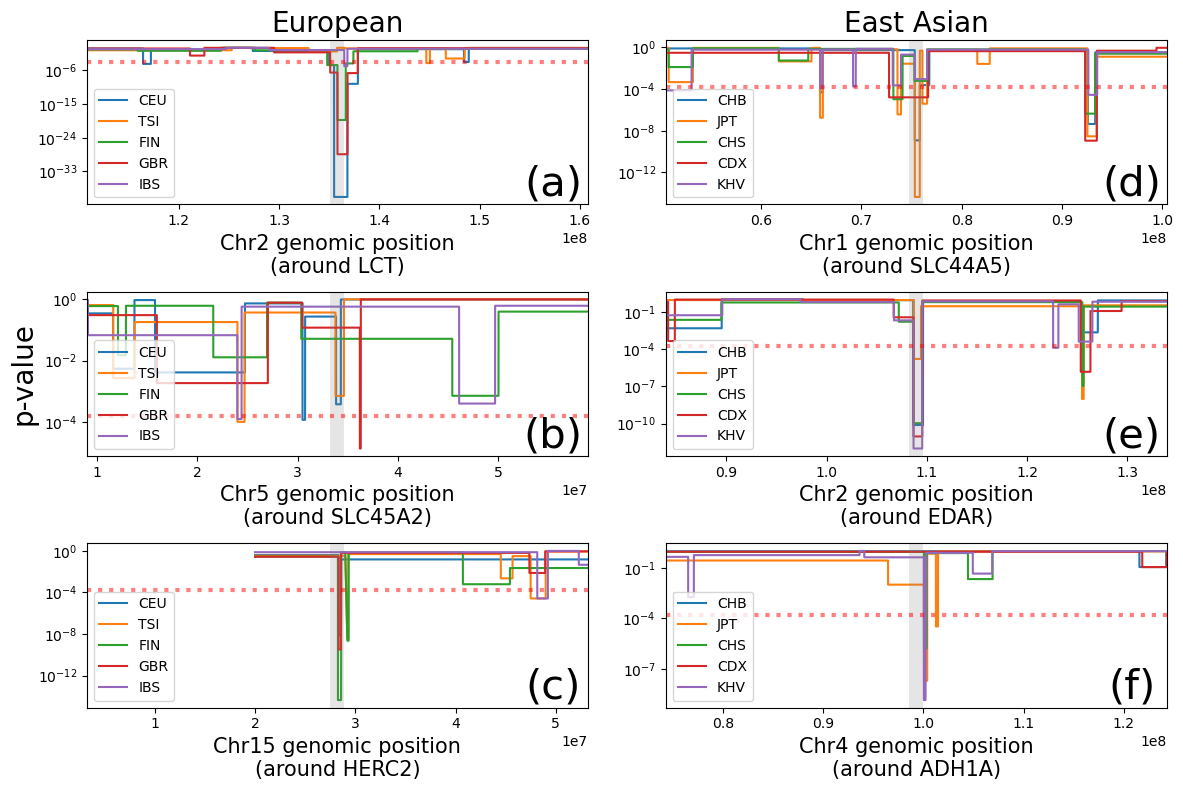

In [27]:
key = 'btreeCmedi'

genes = iter(["LCT", "SLC44A5", "SLC45A2", "EDAR", "HERC2", "ADH1A"])
spops = iter(["EUR", "EAS", "EUR", "EAS", "EUR", "EAS"])

letters = iter(['a', 'd', 'b', 'e', 'c', 'f'])

nrows = 3
ncols = 2
around = 2.5e7

fig, ax = plt.subplots(nrows,ncols,figsize = (12,8))

for i in range(nrows):
    for j in range(ncols):
        gene = next(genes)
        spop = next(spops)
        ret = pscan_by_spop(key, spop, gene = gene, around = around, weights='gaussian', ax = ax[i, j])
        ax[i, j].legend(loc = "lower left")
        ax[i, j].set_xlabel('Chr'+str(ret['chrno'])+' genomic position\n(around '+gene+')', size = 15)
        #ax[i, j].set_ylabel('p-value')
        ax[i, j].axvline(ret['gp'], linewidth = 10, color = 'Gray', alpha = 0.2)
        ax[i, j].set_xlim(ret['gp']-around, ret['gp']+around)
        ax[i, j].axhline(1.6e-4, color = 'red', linestyle = 'dotted', alpha = 0.5, linewidth = 3)
        ax[i, j].text(1-0.07, 0.12, '('+next(letters)+')', fontsize=30,
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax[i, j].transAxes)
        
ax[1, 0].set_ylabel('p-value', fontsize = 20)
#ax[1, 1].set_ylabel('p-value', fontsize = 30)

plt.subplots_adjust(wspace=2)
ax[0, 0].set_title('European', size = 20)
ax[0, 1].set_title('East Asian', size = 20)
fig.tight_layout()
plt.savefig('genome_scan_plots/multiple_genes_'+key+'.jpg', dpi = 300)

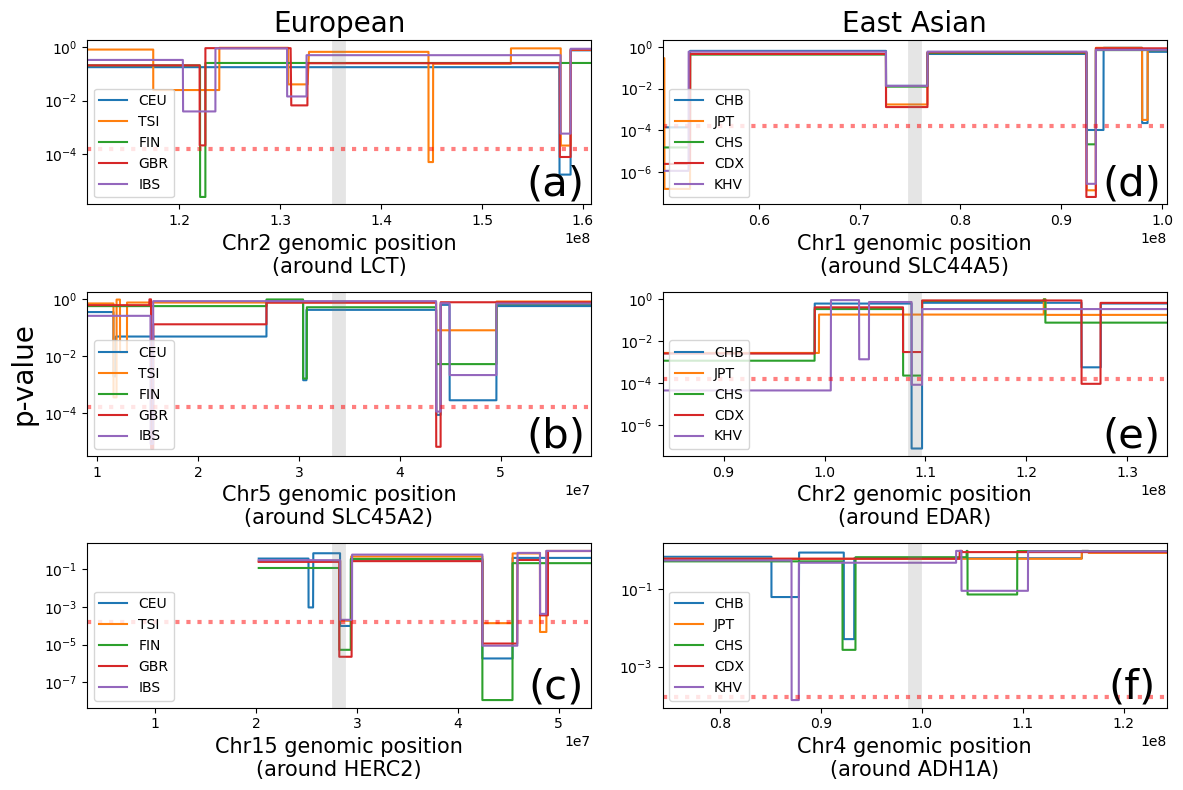

In [28]:
key = 'bsfs'

genes = iter(["LCT", "SLC44A5", "SLC45A2", "EDAR", "HERC2", "ADH1A"])
spops = iter(["EUR", "EAS", "EUR", "EAS", "EUR", "EAS"])

letters = iter(['a', 'd', 'b', 'e', 'c', 'f'])

nrows = 3
ncols = 2
around = 2.5e7

fig, ax = plt.subplots(nrows,ncols,figsize = (12,8))

for i in range(nrows):
    for j in range(ncols):
        gene = next(genes)
        spop = next(spops)
        ret = pscan_by_spop(key, spop, gene = gene, around = around, weights='gaussian', ax = ax[i, j])
        ax[i, j].legend(loc = "lower left")
        ax[i, j].set_xlabel('Chr'+str(ret['chrno'])+' genomic position\n(around '+gene+')', size = 15)
        #ax[i, j].set_ylabel('p-value')
        ax[i, j].axvline(ret['gp'], linewidth = 10, color = 'Gray', alpha = 0.2)
        ax[i, j].set_xlim(ret['gp']-around, ret['gp']+around)
        ax[i, j].axhline(1.6e-4, color = 'red', linestyle = 'dotted', alpha = 0.5, linewidth = 3)
        ax[i, j].text(1-0.07, 0.12, '('+next(letters)+')', fontsize=30,
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax[i, j].transAxes)
        
ax[1, 0].set_ylabel('p-value', fontsize = 20)
#ax[1, 1].set_ylabel('p-value', fontsize = 30)

plt.subplots_adjust(wspace=2)
ax[0, 0].set_title('European', size = 20)
ax[0, 1].set_title('East Asian', size = 20)
fig.tight_layout()
plt.savefig('genome_scan_plots/multiple_genes_'+key+'.jpg', dpi = 300)

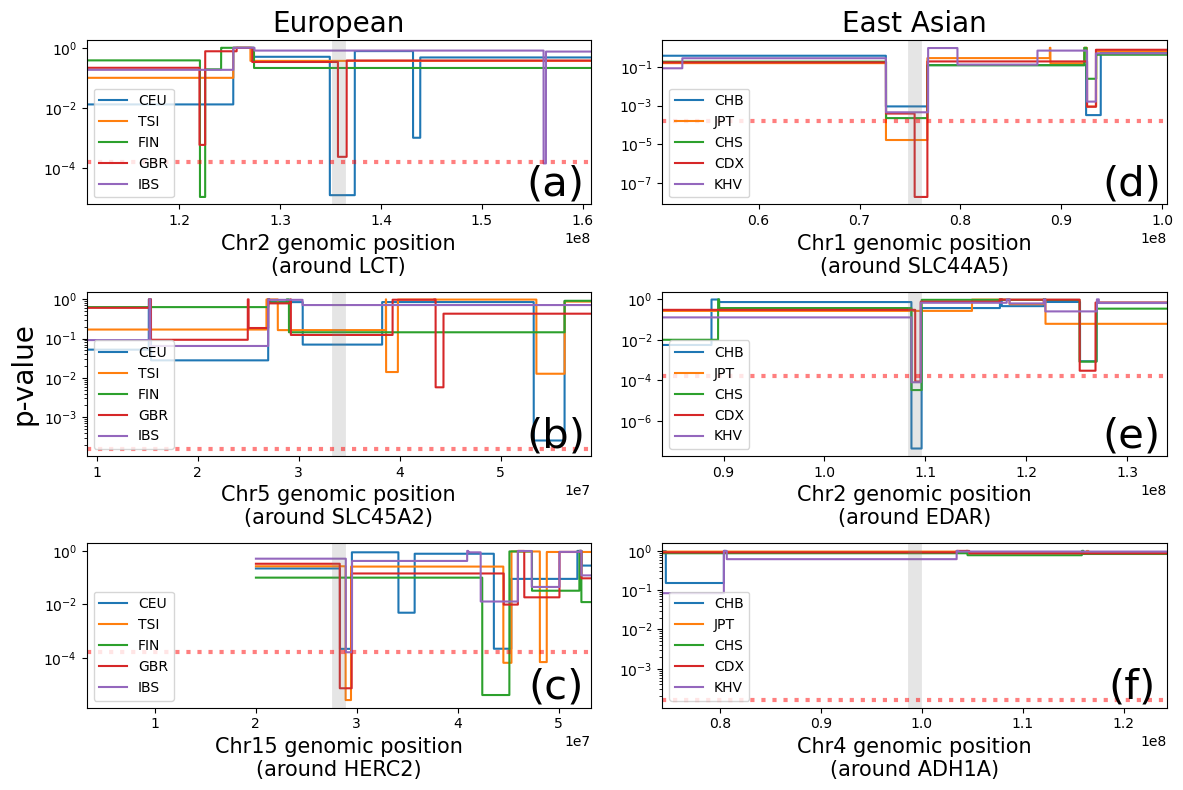

In [31]:
key = 'bsfsCmedi'

genes = iter(["LCT", "SLC44A5", "SLC45A2", "EDAR", "HERC2", "ADH1A"])
spops = iter(["EUR", "EAS", "EUR", "EAS", "EUR", "EAS"])

letters = iter(['a', 'd', 'b', 'e', 'c', 'f'])

nrows = 3
ncols = 2
around = 2.5e7

fig, ax = plt.subplots(nrows,ncols,figsize = (12,8))

for i in range(nrows):
    for j in range(ncols):
        gene = next(genes)
        spop = next(spops)
        ret = pscan_by_spop(key, spop, gene = gene, around = around, weights='gaussian', ax = ax[i, j])
        ax[i, j].legend(loc = "lower left")
        ax[i, j].set_xlabel('Chr'+str(ret['chrno'])+' genomic position\n(around '+gene+')', size = 15)
        #ax[i, j].set_ylabel('p-value')
        ax[i, j].axvline(ret['gp'], linewidth = 10, color = 'Gray', alpha = 0.2)
        ax[i, j].set_xlim(ret['gp']-around, ret['gp']+around)
        ax[i, j].axhline(1.6e-4, color = 'red', linestyle = 'dotted', alpha = 0.5, linewidth = 3)
        ax[i, j].text(1-0.07, 0.12, '('+next(letters)+')', fontsize=30,
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax[i, j].transAxes)
        
ax[1, 0].set_ylabel('p-value', fontsize = 20)
#ax[1, 1].set_ylabel('p-value', fontsize = 30)

plt.subplots_adjust(wspace=2)
ax[0, 0].set_title('European', size = 20)
ax[0, 1].set_title('East Asian', size = 20)
fig.tight_layout()
plt.savefig('genome_scan_plots/multiple_genes_'+key+'.jpg', dpi = 300)

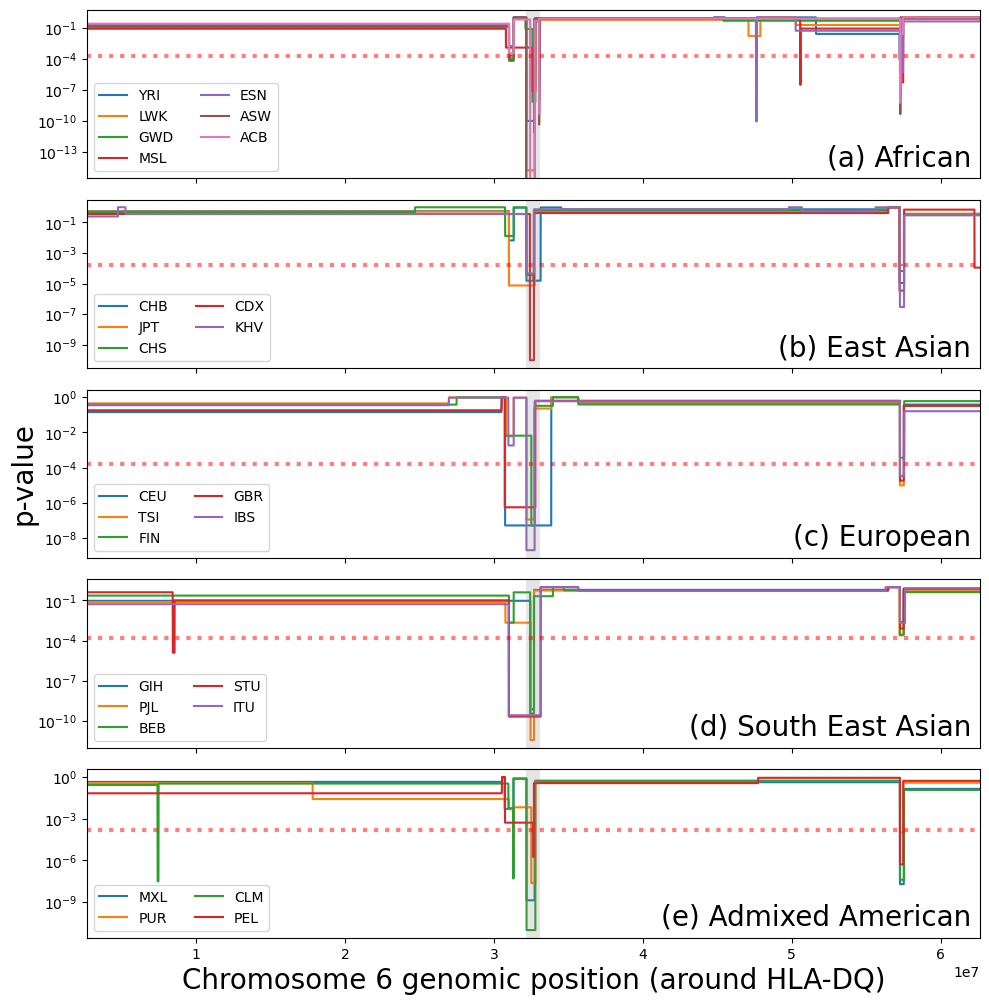

In [29]:
key = 'bsfs'
letters = iter(['(a) African', '(b) East Asian', '(c) European', 
                '(d) South East Asian', '(e) Admixed American'])

fig, ax = plt.subplots(5,1,figsize = (10,10), sharex=True)

around = 3e7

for i, spop in enumerate(['AFR', 'EAS', 'EUR', 'SAS', 'AMR']):
    ret = pscan_by_spop(key, spop, gene = 'HLA-DQA1', around = around, selection = 'balancing', ax = ax[i])
    ax[i].legend(loc = 'lower left', ncol = 2)
    ax[i].text(1-0.01, 0.12, next(letters), fontsize=20,
               horizontalalignment='right',
               verticalalignment='center',
               transform = ax[i].transAxes)
    ax[i].set_xlim(ret['gp']-around, ret['gp']+around)
    ax[i].axvline(ret['gp'], linewidth = 10, color = 'Gray', alpha = 0.2)
    ax[i].axhline(1.6e-4, color = 'red', linestyle = 'dotted', alpha = 0.5, linewidth = 3)
    

ax[2].set_ylabel('p-value', size = 20)
plt.tight_layout()
ax[4].set_xlabel('Chromosome 6 genomic position (around HLA-DQ)', size = 20)
plt.savefig('genome_scan_plots/MHC'+key+'.jpg', dpi = 300)

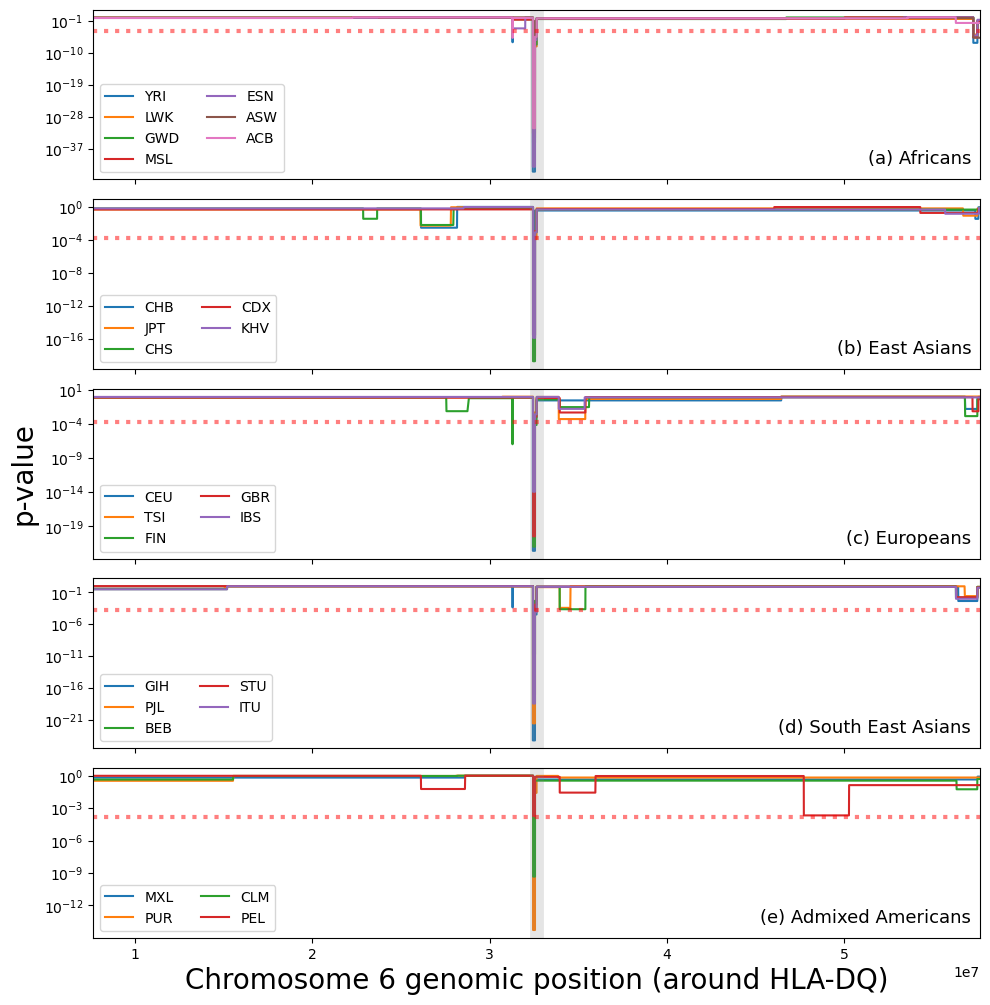

In [32]:
key = 'btree'
letters = iter(['(a) Africans', '(b) East Asians', '(c) Europeans', 
                '(d) South East Asians', '(e) Admixed Americans'])

fig, ax = plt.subplots(5,1,figsize = (10,10), sharex=True)

for i, spop in enumerate(['AFR', 'EAS', 'EUR', 'SAS', 'AMR']):
    ret = pscan_by_spop(key, spop, gene = 'HLA-DQA1', around = 2.5e7, selection = 'directional', ax = ax[i])
    ax[i].legend(loc = 'lower left', ncol = 2)
    ax[i].text(1-0.01, 0.12, next(letters), fontsize=13,
               horizontalalignment='right',
               verticalalignment='center',
               transform = ax[i].transAxes)
    ax[i].set_xlim(ret['gp']-around, ret['gp']+around)
    ax[i].axvline(ret['gp'], linewidth = 10, color = 'Gray', alpha = 0.2)
    ax[i].axhline(1.6e-4, color = 'red', linestyle = 'dotted', alpha = 0.5, linewidth = 3)

ax[2].set_ylabel('p-value', size = 20)
plt.tight_layout()
ax[4].set_xlabel('Chromosome 6 genomic position (around HLA-DQ)', size = 20)
plt.savefig('genome_scan_plots/MHC'+key+'.jpg', dpi = 300)

# Genome-scan statistics with the segment

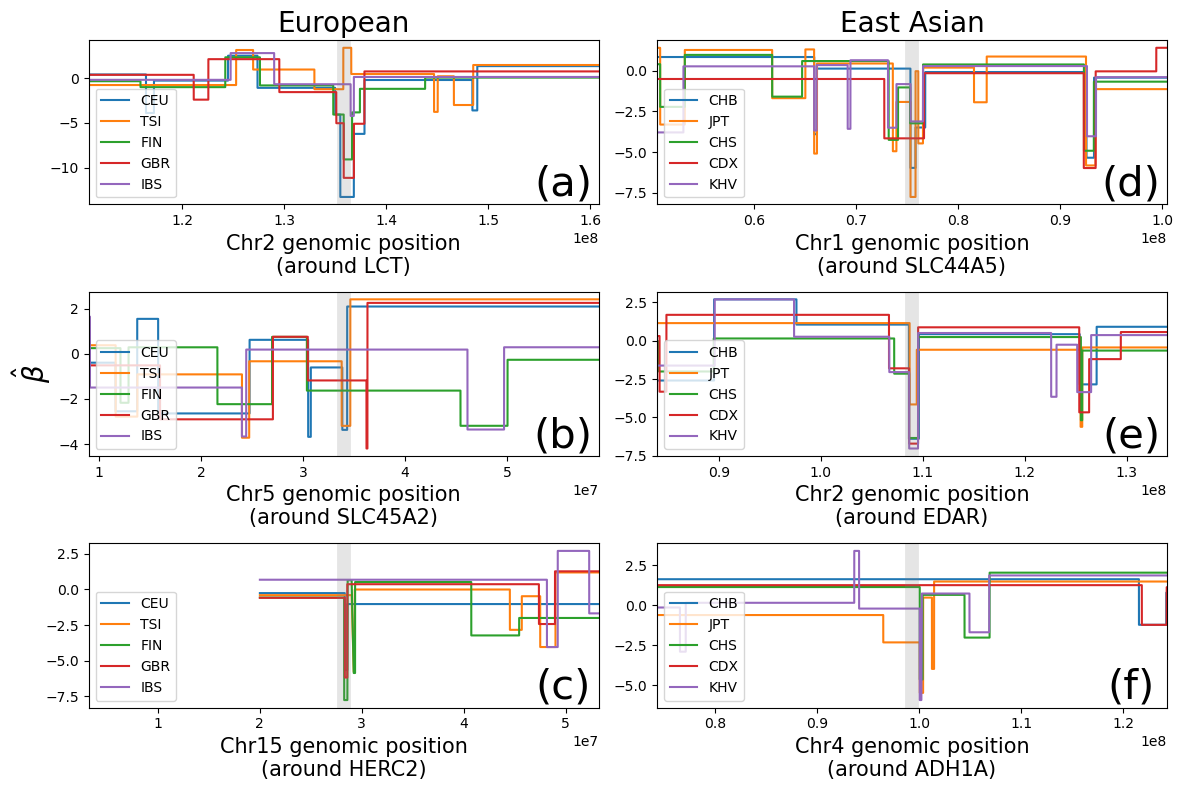

In [24]:
key = 'btreeCmedi'

genes = iter(["LCT", "SLC44A5", "SLC45A2", "EDAR", "HERC2", "ADH1A"])
spops = iter(["EUR", "EAS", "EUR", "EAS", "EUR", "EAS"])

letters = iter(['a', 'd', 'b', 'e', 'c', 'f'])

nrows = 3
ncols = 2
around = 2.5e7

fig, ax = plt.subplots(nrows,ncols,figsize = (12,8))

for i in range(nrows):
    for j in range(ncols):
        gene = next(genes)
        spop = next(spops)
        ret = Zscan_by_spop(key, spop, gene = gene, around = around, weights='gaussian', ax = ax[i, j])
        ax[i, j].legend(loc = "lower left")
        ax[i, j].set_xlabel('Chr'+str(ret['chrno'])+' genomic position\n(around '+gene+')', size = 15)
        ax[i, j].axvline(ret['gp'], linewidth = 10, color = 'Gray', alpha = 0.2)
        ax[i, j].set_xlim(ret['gp']-around, ret['gp']+around)
        #ax[i, j].axhline(1.6e-4, color = 'red', linestyle = 'dotted', alpha = 0.5, linewidth = 3)
        ax[i, j].text(1-0.07, 0.12, '('+next(letters)+')', fontsize=30,
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax[i, j].transAxes)
        
ax[1, 0].set_ylabel(r'$\hat{\beta}$', fontsize = 20)
#ax[1, 1].set_ylabel('p-value', fontsize = 30)

plt.subplots_adjust(wspace=2)
ax[0, 0].set_title('European', size = 20)
ax[0, 1].set_title('East Asian', size = 20)
fig.tight_layout()
plt.savefig('genome_scan_plots/multiple_genes_'+key+'_gs.jpg', dpi = 300)

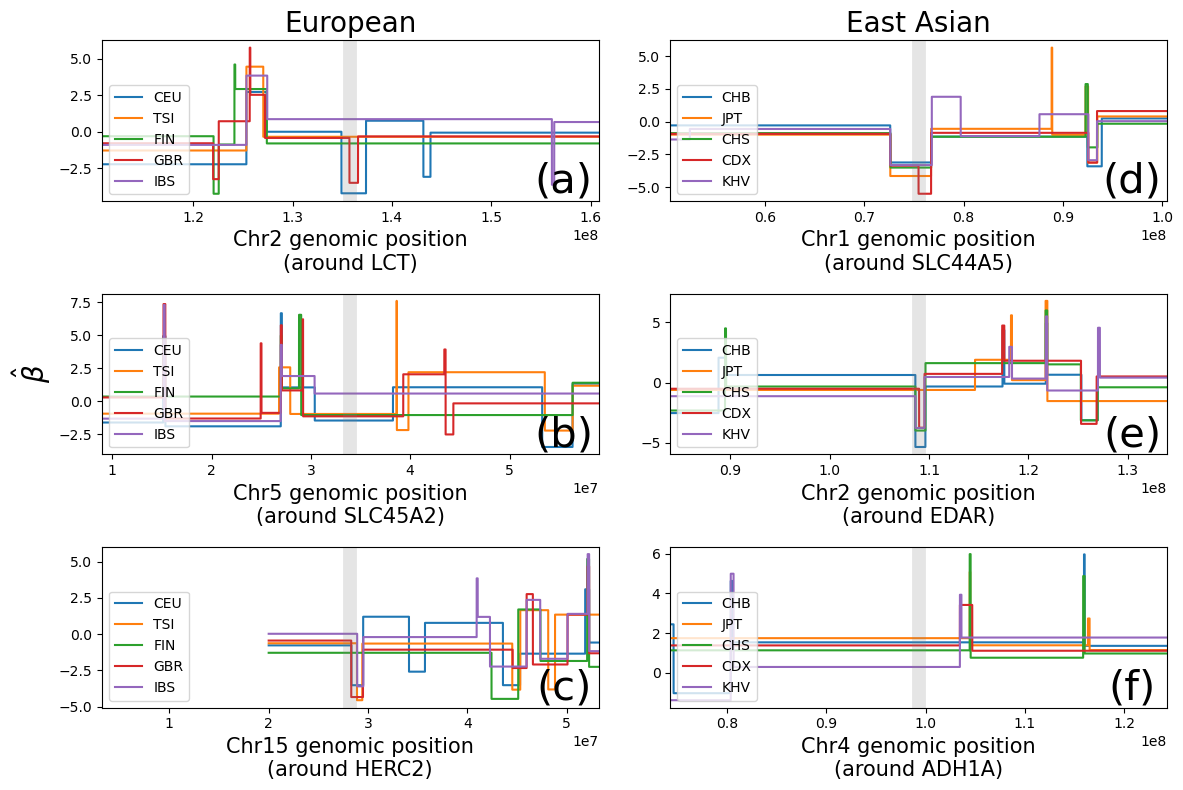

In [22]:
key = 'bsfsCmedi'

genes = iter(["LCT", "SLC44A5", "SLC45A2", "EDAR", "HERC2", "ADH1A"])
spops = iter(["EUR", "EAS", "EUR", "EAS", "EUR", "EAS"])

letters = iter(['a', 'd', 'b', 'e', 'c', 'f'])

nrows = 3
ncols = 2
around = 2.5e7

fig, ax = plt.subplots(nrows,ncols,figsize = (12,8))

for i in range(nrows):
    for j in range(ncols):
        gene = next(genes)
        spop = next(spops)
        ret = Zscan_by_spop(key, spop, gene = gene, around = around, weights='gaussian', ax = ax[i, j])
        ax[i, j].legend(loc = "lower left")
        ax[i, j].set_xlabel('Chr'+str(ret['chrno'])+' genomic position\n(around '+gene+')', size = 15)
        ax[i, j].axvline(ret['gp'], linewidth = 10, color = 'Gray', alpha = 0.2)
        ax[i, j].set_xlim(ret['gp']-around, ret['gp']+around)
        #ax[i, j].axhline(1.6e-4, color = 'red', linestyle = 'dotted', alpha = 0.5, linewidth = 3)
        ax[i, j].text(1-0.07, 0.12, '('+next(letters)+')', fontsize=30,
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax[i, j].transAxes)
        
ax[1, 0].set_ylabel(r'$\hat{\beta}$', fontsize = 20)
#ax[1, 1].set_ylabel('p-value', fontsize = 30)

plt.subplots_adjust(wspace=2)
ax[0, 0].set_title('European', size = 20)
ax[0, 1].set_title('East Asian', size = 20)
fig.tight_layout()
plt.savefig('genome_scan_plots/multiple_genes_'+key+'_gs.jpg', dpi = 300)

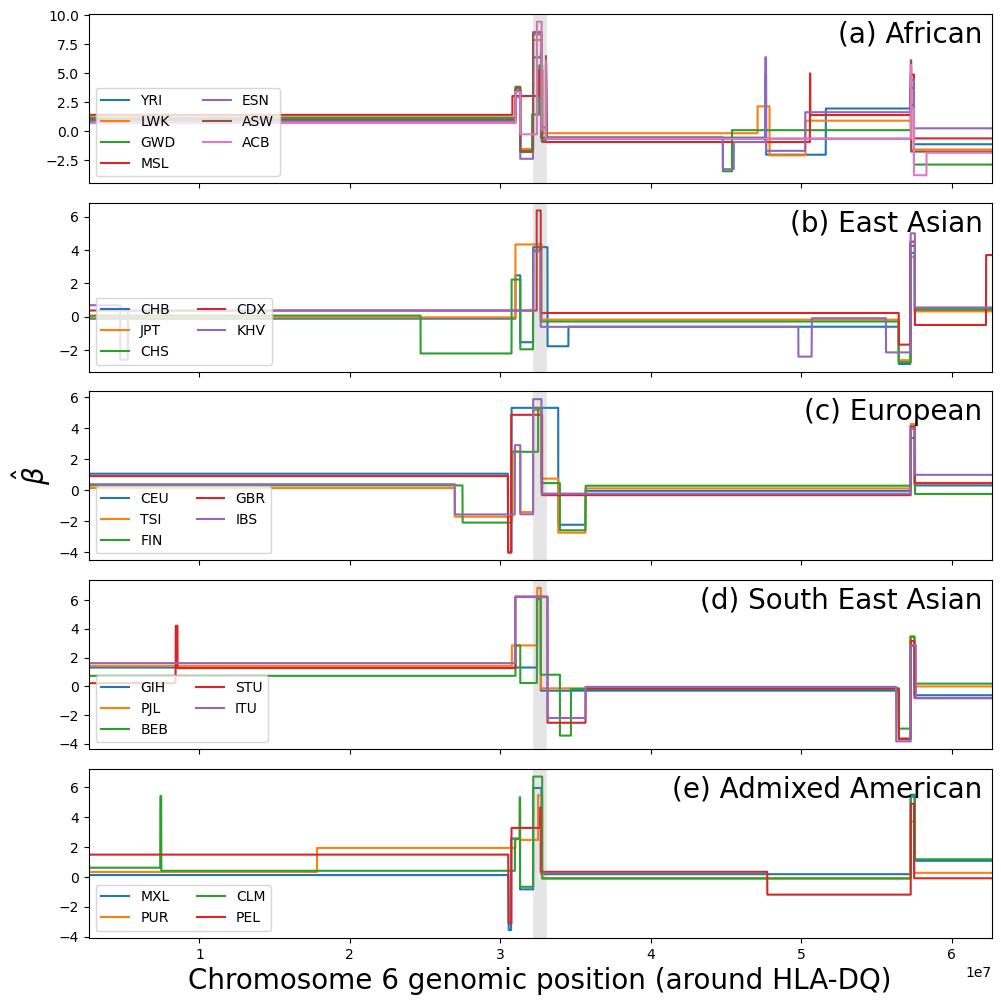

In [21]:
key = 'bsfs'
letters = iter(['(a) African', '(b) East Asian', '(c) European', 
                '(d) South East Asian', '(e) Admixed American'])

fig, ax = plt.subplots(5,1,figsize = (10,10), sharex=True)

around = 3e7

for i, spop in enumerate(['AFR', 'EAS', 'EUR', 'SAS', 'AMR']):
    ret = Zscan_by_spop(key, spop, gene = 'HLA-DQA1', around = around, ax = ax[i])
    ax[i].legend(loc = 'lower left', ncol = 2)
    ax[i].text(1-0.01, 1-0.12, next(letters), fontsize=20,
               horizontalalignment='right',
               verticalalignment='center',
               transform = ax[i].transAxes)
    ax[i].set_xlim(ret['gp']-around, ret['gp']+around)
    ax[i].axvline(ret['gp'], linewidth = 10, color = 'Gray', alpha = 0.2)
    #ax[i].axhline(1.6e-4, color = 'red', linestyle = 'dotted', alpha = 0.5, linewidth = 3)
    

ax[2].set_ylabel(r'$\hat{\beta}$', size = 20)
plt.tight_layout()
ax[4].set_xlabel('Chromosome 6 genomic position (around HLA-DQ)', size = 20)
plt.savefig('genome_scan_plots/MHC'+key+'_gs.jpg', dpi = 300)

## ------------Dont Run

In [10]:
df = pd.read_csv('merged/s0Cmedi.csv')

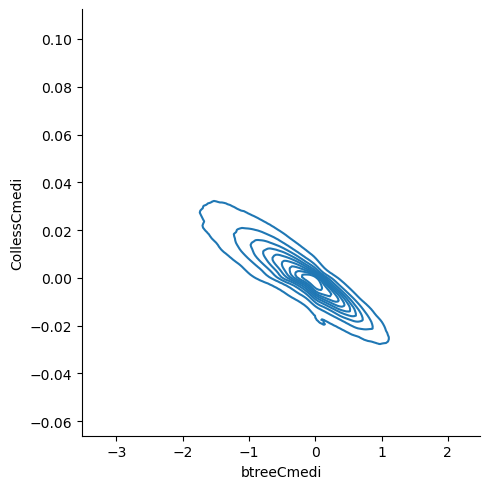

In [14]:
p = sns.displot(df, x="btreeCmedi", y="CollessCmedi", kind="kde")

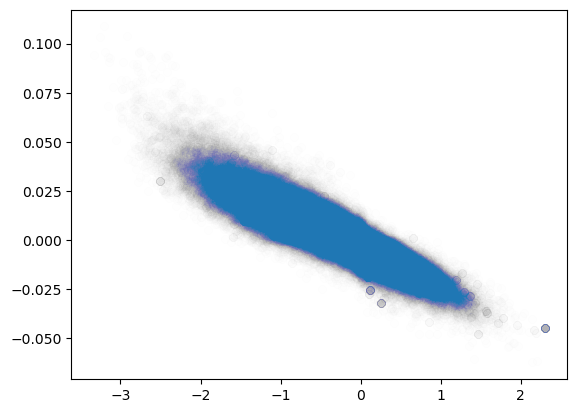

In [11]:
plt.plot(df['btreeCmedi'], df['CollessCmedi'], 'o', alpha = 0.004)
# use contour

In [25]:
around = 2.5e7
gene = 'LCT'
pop = 5
spop = 'EUR'

key = 'btreeCmedi'

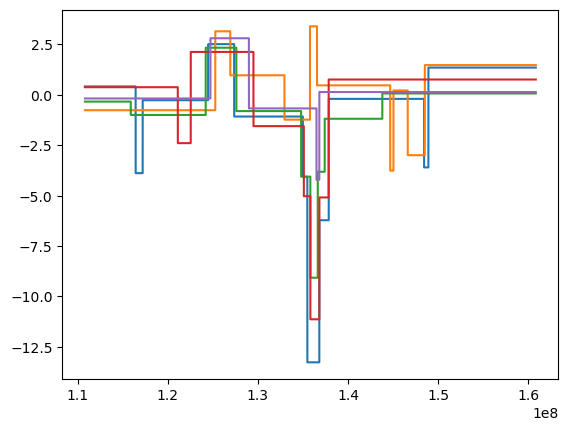

In [28]:
ret = Zscan_by_spop(key, spop, gene = gene, around = around, weights='gaussian', ax = plt)

In [17]:
x = ann.loc[gene]

chrno = x['Chromosome']
start = x['start']-around
end = x['end']+around     

In [18]:


if key[-5:] == 'Cmedi':
    df = pd.read_csv('merged/s'+str(pop)+'Cmedi.csv')
else:
    df = pd.read_csv('merged/s'+str(pop)+'.csv')
dx = df[(df['start']>start)&(df['end']<end)]

In [19]:
mu_g = df[key].mean()
df = df[df['Chromosome'] == chrno].copy()        

df = df[(df['start']>start)&(df['end']<end)]
cov = pd.read_csv('lags/'+key+'.csv').loc[:,str(pop)].to_numpy()
cps, zvals = segment_to_Z(df, key, mu_g, cov)

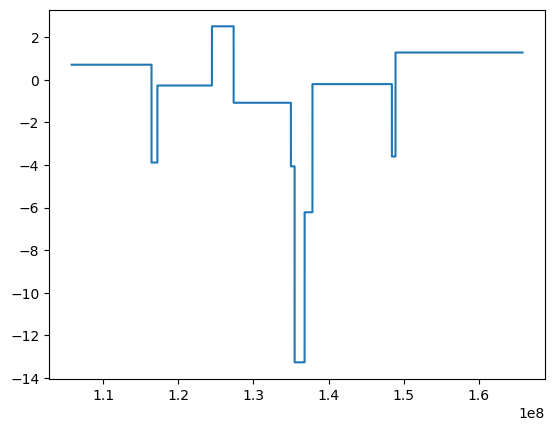

In [21]:
plt.plot(cps, zvals)

In [66]:
dx[key].mean()

-0.027562557206497338

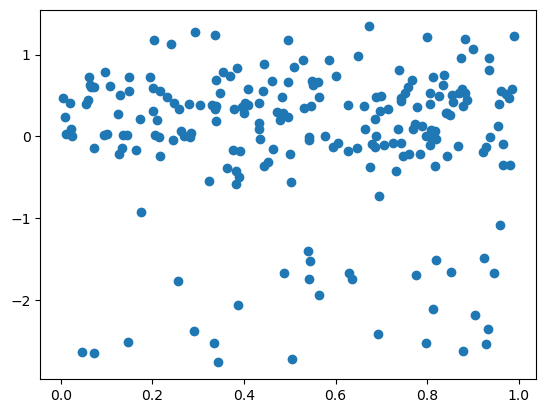

In [67]:
plt.plot(np.zeros(dx.shape[0])+np.random.rand(dx.shape[0]), dx[key], 'o')